In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from scipy.linalg import norm
from statsmodels.tsa.stattools import acf
import tensorflow as tf
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import os
import sklearn
import random

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)



# Utility Functions

In [131]:
# Function to clean filename
def clean_filename(filename):
    # Remove 'test' or 'train' from the beginning
    if filename.startswith('test'):
        filename = filename[4:]  # Remove 'test' (4 characters)
    elif filename.startswith('train'):
        filename = filename[5:]  # Remove 'train' (5 characters)

    # Remove '.npy' from the end
    if filename.endswith('.npy'):
        filename = filename[:-4]  # Remove '.npy' (4 characters)

    return filename

In [132]:
# Function to process all files in a directory
def process_directory(directory_path, data_dict):
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(directory_path, file_name)
            clean_file_name = clean_filename(file_name)
            file_data = np.load(file_path)
            if clean_file_name in data_dict:
                data_dict[clean_file_name] = np.concatenate((data_dict[clean_file_name], file_data), axis=0)
            else:
                data_dict[clean_file_name] = file_data

In [133]:
#  np function to z normlize and return array

def z_normalize(array):
  """
  Z-normalizes an array by subtracting the mean and dividing by the standard deviation.
  """
  mean = np.mean(array, axis=0)
  std = np.std(array, axis=0)
  return (array - mean) / std


In [134]:

def compute_features(data, all_activities):
    for i in range(all_activities.shape[0]):

        # Initialize an empty list to hold statistics for this sample
        stats = []

        # Maximum
        stats.append(np.max(all_activities[i], axis = 0))

        # Minimum
        stats.append(np.min(all_activities[i], axis = 0))

        # First-order mean
        mean_val = np.mean(all_activities[i], axis = 0)
        stats.append(mean_val)

        # Standard Deviation
        stats.append(np.std(all_activities[i], axis = 0))

        # Percentile 50
        stats.append(np.percentile(all_activities[i], 50, axis = 0))

        # Percentile 80
        stats.append(np.percentile(all_activities[i], 80, axis = 0))

        # Norm of the first-order mean
        stats.append(np.full(mean_val.shape, norm(mean_val)))

        # Average (same as mean)
        stats.append(mean_val)

        # Interquartile range
        stats.append(np.percentile(all_activities[i], 75, axis = 0) - np.percentile(all_activities[i], 25, axis = 0))

        # Second-order mean
        squared_mean = np.mean(np.square(all_activities[i]), axis = 0)
        stats.append(squared_mean)

        # Skewness
        stats.append(skew(all_activities[i], axis = 0))

        # Norm of the second-order mean
        stats.append(np.full(squared_mean.shape, norm(squared_mean)))

        # Zero-crossing
        zero_crossings = np.sum(np.diff(np.sign(all_activities[i]), axis = 0) != 0, axis = 0)
        stats.append(zero_crossings)

        # Kurtosis
        stats.append(kurtosis(all_activities[i], axis = 0))

        # Spectral energy
        frequencies, power_spectral_density = welch(all_activities[i], axis = 0)
        spectral_energy = np.sum(power_spectral_density, axis = 0)
        stats.append(spectral_energy)

        # Percentile 20
        stats.append(np.percentile(all_activities[i], 20, axis = 0))

        # Auto-correlation (assuming lag 1)
        autocorr = np.array([acf(all_activities[i][:, j], nlags = 1, fft = True)[1] for j in range(all_activities[i].shape[1])])
        stats.append(autocorr)

        # Spectral entropy
        power_spectral_density /= np.sum(power_spectral_density, axis = 0, keepdims = True)
        spectral_entropy = entropy(power_spectral_density, axis = 0)
        stats.append(spectral_entropy)

        # Convert list of arrays to a 2D array of shape (18, 3)
        stats_array = np.array(stats)

        # Store in pre-allocated data array
        data[i] = stats_array



# **Step:1+2** Reading Data and Storing in Numpy Arrays


In [135]:
#to store the all the numpy arrays data
data = {}

# Define the path to the training and testing directories
training_path = '/content/drive/MyDrive/ActivityData/training'
testing_path = '/content/drive/MyDrive/ActivityData/testing'

# Process training and testing data
process_directory(training_path, data)
process_directory(testing_path, data)

# Prepropressing of Data


*   Applying Z-normalization
*   Flattening single 2D example into 1D Vector



In [136]:
# Print the shapes of the merged arrays
for filename,np_array in data.items():
    print(f"{filename}: {np_array.shape}")

Accelerometer: (4572, 800, 3)
Gyroscope: (4572, 800, 3)
Gravity: (4572, 800, 3)
JinsGyroscope: (4572, 80, 3)
JinsAccelerometer: (4572, 80, 3)
MSGyroscope: (4572, 268, 3)
LinearAcceleration: (4572, 800, 3)
Magnetometer: (4572, 200, 3)
MSAccelerometer: (4572, 268, 3)


#  Feature Extraction




In [137]:
NUM_EXAMPLES = 4572


for filename,data_array in data.items():
  container = np.empty((NUM_EXAMPLES , 18,3))
  compute_features(container ,data_array)
  data[filename] = container

<ipython-input-134-c6e1e559c6da>:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.append(skew(all_activities[i], axis = 0))
<ipython-input-134-c6e1e559c6da>:50: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.append(kurtosis(all_activities[i], axis = 0))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
<ipython-input-134-c6e1e559c6da>:65: RuntimeWarning: invalid value encountered in divide
  power_spectral_density /= np.sum(power_spectral_density, axis = 0, keepdims = True)
/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 80, using n

# Preprocessing on Extracted Features

### Z-normalization for faster convergence and better accuracy


In [138]:

print(f"Before Normalization: {data['Gravity'][1][:2]}")

for filename,np_array in data.items():
  data[filename] = z_normalize(np_array)

print(f"After Normalization: {data['Gravity'][1][:2]}")

Before Normalization: [[ 0.68000001  9.80999947  0.70999998]
 [-1.26999998  9.34000015 -2.99000001]]
After Normalization: [[-0.24926939  0.74928326  0.82207081]
 [-0.45222526  0.8670593   0.49503267]]


### Step:3.2. Flattening the examples

In [139]:
for filename,np_array in data.items():
  data[filename] = np.reshape(np_array , (NUM_EXAMPLES, -1))
  print(data[filename].shape)

(4572, 54)
(4572, 54)
(4572, 54)
(4572, 54)
(4572, 54)
(4572, 54)
(4572, 54)
(4572, 54)
(4572, 54)


In [140]:
data_arrays = np.concatenate([np_array for np_array in data.values()] , axis=1)
data_arrays.shape

(4572, 486)

## Save the final data to avoid pre-processing again

In [141]:
# Define the path to save the processed data
save_path = '/content/drive/MyDrive/ActivityData/Processed/V3'

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the data
np.save(os.path.join(save_path, 'Data.npy'), data, )

# Load Pre-Processed Data

In [142]:
original_data = np.load('/content/drive/MyDrive/ActivityData/Processed/Data.npy')
train_labels = np.load('/content/drive/MyDrive/ActivityData/trainLabels.npy')
test_labels = np.load('/content/drive/MyDrive/ActivityData/testLabels.npy')
Labels = np.concatenate([train_labels, test_labels])
print(Labels.shape)

(4572,)


In [143]:
original_data.shape

(4572, 486)

In [144]:
# Create an imputer object with a strategy (e.g., 'mean', 'median', 'most_frequent')
imputer = SimpleImputer(strategy='mean')
# Fit and transform the data
original_data = imputer.fit_transform(original_data)

## Finding the best number of components by using PCA again and again

In [145]:
best_acc = 0
best_i = 0


# For analysis
no_of_features_list = []
accuracy_list = []





for i in range(100,400):

  data = original_data

  # Apply PCA
  desired_number_of_components = 320  # Adjust based on explained variance
  pca = PCA(n_components=desired_number_of_components)
  data = pca.fit_transform(data)


  X_train, X_test, y_train, y_test = train_test_split(data, Labels, test_size=0.2)

  clf = svm.SVC(kernel='linear')
  clf.fit(X_train, y_train)


  y_pred = clf.predict(X_test)

  # Accuracy
  accuracy = accuracy_score(y_test, y_pred)

  no_of_features_list.append(i)
  accuracy_list.append(accuracy)

  if accuracy > best_acc:
    print(f"i:{i}   acc:{accuracy}")
    best_acc = accuracy
    best_i = i




i:100   acc:0.8098360655737705
i:101   acc:0.8131147540983606
i:106   acc:0.8142076502732241
i:109   acc:0.833879781420765
i:297   acc:0.839344262295082
i:358   acc:0.8415300546448088


In [212]:

# Save the arrays
# Define the path to save the processed data
save_path = '/content/drive/MyDrive/ActivityData/Processed/'

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the data
np.save(os.path.join(save_path, 'features_list.npy'), np.array([no_of_features_list]))
np.save(os.path.join(save_path, 'accuracy_list.npy'), np.array([accuracy_list]))

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

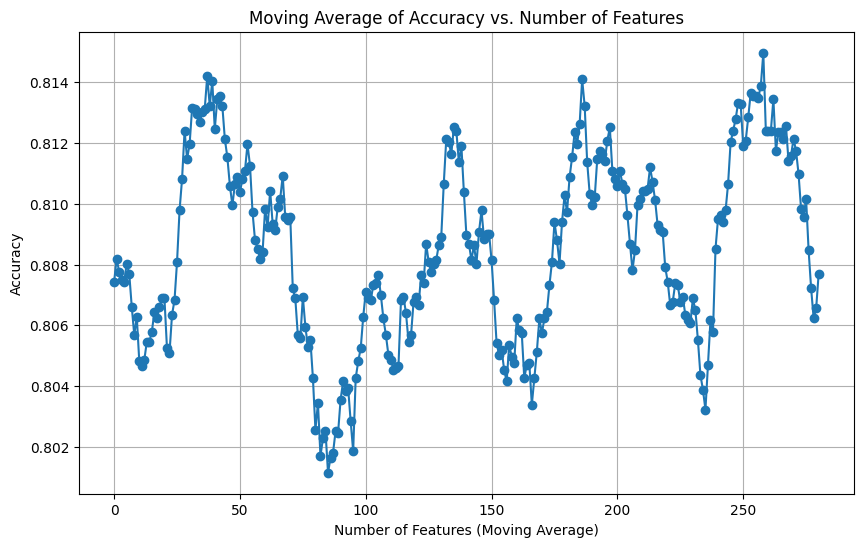

In [222]:

# Moving avg to avoid fluctuation
window_size = 20
moving_average = [np.mean(accuracy_list[i:i+window_size]) for i in range(len(accuracy_list) - window_size + 1)]

# Plot the moving average of the accuracy
plt.figure(figsize=(10, 6))
plt.plot(moving_average, 'o-')
plt.xlabel('Number of Features (Moving Average)')
plt.ylabel('Accuracy')
plt.title('Moving Average of Accuracy vs. Number of Features')
plt.grid(True)
plt.show()


In [213]:
print(best_acc)
print(best_i)

0.8415300546448088
358


In [214]:
data = original_data
data.shape

(4572, 469)

# Applying Feature Selection Method (PCA)

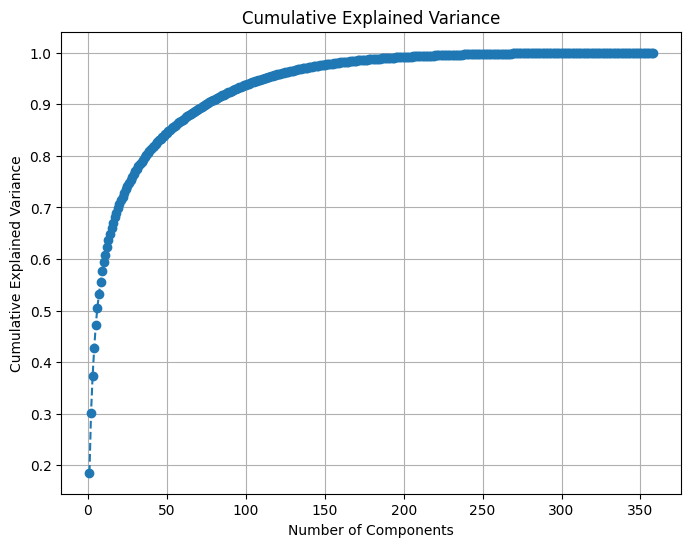

In [215]:
# Apply PCA for best number of features
desired_number_of_components = best_i  # Adjust based on explained variance
pca = PCA(n_components=desired_number_of_components)
data = pca.fit_transform(data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)


plt.figure(figsize=(8, 6))
plt.plot(range(1, desired_number_of_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [205]:
X_train, X_test, y_train, y_test = train_test_split(data, Labels, test_size=0.2)

In [206]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3657, 200)
(3657,)
(915, 200)
(915,)


# Applying First Method (SVM)

In [207]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [208]:
y_pred = clf.predict(X_test)

# Evaluation Methods

## Note: The accuracy fluctuates between 80-84 % due to randomness. The max accuracy achieved was 84%.

In [209]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8076502732240437
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       1.00      0.90      0.95        20
           2       0.73      0.92      0.81        12
           3       0.80      0.80      0.80        15
           4       0.75      0.95      0.84        19
           5       0.55      0.40      0.46        15
           6       0.79      0.90      0.84        21
           7       0.38      0.44      0.41        18
           8       0.64      0.64      0.64        22
           9       0.71      1.00      0.83         5
          10       0.88      0.82      0.85        17
          11       0.86      1.00      0.92        12
          12       1.00      1.00      1.00        16
          13       0.82      0.88      0.85        16
          14       0.94      0.94      0.94        17
          15       1.00      0.92      0.96        12
          16       0.89      

# Using Random Forest Algorithm for Comparison

In [224]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.73


In [223]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Precision: 0.7449959141415706
Recall: 0.7289617486338797
F1 Score: 0.7259908080150671
